In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GRU, Dense, Dropout, BatchNormalization,Bidirectional, LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
# Load CSV
df = pd.read_csv("../Datasets/CSV_DATASET/gait_keypoints.csv")

In [3]:
df

,K0_x,K0_y,K0_z,K0_visibility,K1_x,K1_y,K1_z,K1_visibility,K2_x,K2_y,...,K30_visibility,K31_x,K31_y,K31_z,K31_visibility,K32_x,K32_y,K32_z,K32_visibility,label
0,0.544438,0.311799,-0.491928,0.999985,0.550760,0.302966,-0.457777,0.999956,0.554709,0.302936,...,0.727806,0.558707,0.712873,0.147720,0.975578,0.469627,0.707786,0.103613,0.960170,0
1,0.544429,0.312831,-0.539714,0.999986,0.550742,0.303536,-0.507108,0.999956,0.554873,0.303603,...,0.736965,0.560770,0.713326,0.123384,0.975932,0.469267,0.707753,0.095728,0.961618,0
2,0.544420,0.313358,-0.536183,0.999986,0.550721,0.303807,-0.503395,0.999956,0.554974,0.303904,...,0.745172,0.562135,0.713639,0.126704,0.976206,0.468989,0.707734,0.086965,0.962904,0
3,0.544412,0.313716,-0.552992,0.999986,0.550704,0.304033,-0.519973,0.999957,0.555055,0.304152,...,0.752738,0.563478,0.714173,0.144464,0.976483,0.468926,0.707861,0.089896,0.964261,0
4,0.544409,0.313985,-0.541478,0.999986,0.550690,0.304216,-0.508349,0.999957,0.555118,0.304348,...,0.759676,0.563592,0.714303,0.138728,0.976682,0.467939,0.707868,0.091107,0.965331,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129,0.670237,-0.185817,0.010160,0.990551,0.637036,-0.201674,-0.102652,0.988985,0.622021,-0.201377,...,0.871135,0.461177,0.589925,1.202271,0.847898,0.703530,0.678279,1.041932,0.757861,4
2130,0.671349,-0.166190,-0.003337,0.991454,0.642305,-0.178645,-0.109127,0.990045,0.627943,-0.177255,...,0.877085,0.465175,0.596421,1.105750,0.846985,0.702633,0.673174,1.048200,0.760549,4
2131,0.655922,-0.165993,0.029245,0.992248,0.627492,-0.178381,-0.085604,0.990983,0.612966,-0.176982,...,0.883612,0.461193,0.599115,0.979052,0.845224,0.699980,0.670868,0.979459,0.766323,4
2132,0.618458,-0.155417,0.016472,0.992729,0.592696,-0.167426,-0.098251,0.991574,0.579236,-0.165696,...,0.889047,0.443759,0.592449,1.042519,0.840276,0.698442,0.672979,0.998246,0.769659,4


## Data splitting

In [4]:
# new_df = df

# X = new_df.iloc[:, :-1].values  
# y = new_df['label'].values      


# # x= independent , y output
# new_df_scaler = StandardScaler()     
# X = new_df_scaler.fit_transform(X)


# X = X.reshape(X.shape[0], 33, 4) 


# num_classes = len(np.unique(y))
# y = to_categorical(y, num_classes)



# New_X_train, New_X_test, New_y_train, New_y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )



import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Copy the original DataFrame
new_df = df.copy()

# Extract features (X) and labels (y)
X = new_df.iloc[:, :-1].values  
y = new_df['label'].values

# One-hot encode labels
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes)

# Train-test split (stratify ensures balanced classes)
New_X_train, New_X_test, New_y_train, New_y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# StandardScaler requires 2D input, so reshape X to (samples, features)
new_df_scaler = StandardScaler()
New_X_train = new_df_scaler.fit_transform(New_X_train)  
New_X_test = new_df_scaler.transform(New_X_test)  # Use the same scaler for test data

# Reshape back to (samples, 33, 4) - Correcting train & test shape mismatch
New_X_train = New_X_train.reshape(New_X_train.shape[0], 33, 4)
New_X_test = New_X_test.reshape(New_X_test.shape[0], 33, 4)


In [5]:
with open("../Models/scaler.pkl", "wb") as f:
    pickle.dump(new_df_scaler, f)

## Model Creation and training

In [6]:
def create_CNN_LSTM_model(input_shape, num_classes):
    model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
            BatchNormalization(),

            Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
            BatchNormalization(),

            Bidirectional(LSTM(128, return_sequences=False)),

            Dense(64, activation='relu'),
            Dropout(0.4),  
            Dense(num_classes, activation='softmax') 
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [7]:
def create_CNN_GRU_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        Bidirectional(GRU(128, return_sequences=False)),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [8]:
def create_RNN_model(input_shape, num_classes):
    model = Sequential([
        SimpleRNN(128, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dense, Dropout, LSTM, Input, Bidirectional, Reshape

def create_autoencoder(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = Bidirectional(LSTM(128, return_sequences=False))(x)
    
    x = Dense(128, activation='relu')(encoded)
    x = Dense(input_shape[0] * input_shape[1], activation='sigmoid')(x)
    decoded = Reshape((input_shape[0], input_shape[1]))(x)  # Fix applied here
    
    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, encoder

def create_classification_model(encoder, num_classes):
    inputs = encoder.input
    x = encoder.output
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

autoencoder, encoder = create_autoencoder((33, 4))
classification_model = create_classification_model(encoder, num_classes)


In [10]:
models = {
    'CNN_GRU': create_CNN_GRU_model((33, 4), num_classes),
    'RNN': create_RNN_model((33, 4), num_classes),
    'CNN_LSTM': create_CNN_LSTM_model((33, 4), num_classes),
    'Autoencoder_Classifier': classification_model
}

d:\AI_ML_PROJECTS\Biomechanics-of-gait - Copy\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\AI_ML_PROJECTS\Biomechanics-of-gait - Copy\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
import json
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

results = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Callbacks for better training
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(f'../Models/{model_name}.h5', save_best_only=True)
    ]

    history = model.fit(New_X_train, New_y_train, epochs=15, batch_size=64, 
                        validation_data=(New_X_test, New_y_test), verbose=1, callbacks=callbacks)

    test_loss, test_acc = model.evaluate(New_X_test, New_y_test, verbose=1)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")

    # Save training history
    with open(f'../Models/{model_name}_history.json', 'w') as f:
        json.dump(history.history, f)

    results[model_name] = {
        'model': model,
        'history': history.history,  # Convert history to a dictionary
        'test_accuracy': test_acc
    }


Training CNN_GRU...
Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5905 - loss: 1.0605

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5956 - loss: 1.0494 - val_accuracy: 0.6581 - val_loss: 1.1727
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8864 - loss: 0.3508

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8868 - loss: 0.3493 - val_accuracy: 0.7307 - val_loss: 0.9235
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9219 - loss: 0.2032

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9219 - loss: 0.2034 - val_accuracy: 0.8080 - val_loss: 0.7556
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9588 - loss: 0.1335

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9589 - loss: 0.1332 - val_accuracy: 0.7307 - val_loss: 0.6934
Epoch 5/15
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9612 - loss: 0.1148

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9611 - loss: 0.1149 - val_accuracy: 0.7143 - val_loss: 0.6362
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9787 - loss: 0.0820

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9787 - loss: 0.0817 - val_accuracy: 0.8525 - val_loss: 0.4317
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9853 - loss: 0.0519

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9853 - loss: 0.0520 - val_accuracy: 0.9110 - val_loss: 0.2704
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9899 - loss: 0.0400

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9898 - loss: 0.0400 - val_accuracy: 0.9204 - val_loss: 0.2137
Epoch 9/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9873 - loss: 0.0463

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9872 - loss: 0.0466 - val_accuracy: 0.9625 - val_loss: 0.1287
Epoch 10/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9894 - loss: 0.0416

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9895 - loss: 0.0412 - val_accuracy: 0.9602 - val_loss: 0.1181
Epoch 11/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9939 - loss: 0.0217

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9939 - loss: 0.0218 - val_accuracy: 0.9672 - val_loss: 0.0745
Epoch 12/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9900 - loss: 0.0273

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9901 - loss: 0.0272 - val_accuracy: 0.9859 - val_loss: 0.0350
Epoch 13/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9984 - loss: 0.0134

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9983 - loss: 0.0135 - val_accuracy: 0.9930 - val_loss: 0.0185
Epoch 14/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9948 - loss: 0.0205

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9948 - loss: 0.0205 - val_accuracy: 0.9930 - val_loss: 0.0185
Epoch 15/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9986 - loss: 0.0100 - val_accuracy: 0.9883 - val_loss: 0.0205
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9945 - loss: 0.0166
CNN_GRU Test Accuracy: 0.9930
Training RNN...
Epoch 1/15
19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3305 - loss: 1.5056

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3665 - loss: 1.4452 - val_accuracy: 0.5738 - val_loss: 0.9571
Epoch 2/15
19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5959 - loss: 0.9708

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6043 - loss: 0.9444 - val_accuracy: 0.7939 - val_loss: 0.6188
Epoch 3/15
19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7752 - loss: 0.6141

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7768 - loss: 0.6046 - val_accuracy: 0.8689 - val_loss: 0.4171
Epoch 4/15
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8429 - loss: 0.4456

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8432 - loss: 0.4450 - val_accuracy: 0.8946 - val_loss: 0.3033
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8605 - loss: 0.3842 - val_accuracy: 0.8571 - val_loss: 0.3932
Epoch 6/15
20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8747 - loss: 0.3686

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8778 - loss: 0.3535 - val_accuracy: 0.9274 - val_loss: 0.2070
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8966 - loss: 0.3149 - val_accuracy: 0.8759 - val_loss: 0.3296
Epoch 8/15
19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8991 - loss: 0.3110

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9035 - loss: 0.2989 - val_accuracy: 0.9133 - val_loss: 0.1905
Epoch 9/15
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9435 - loss: 0.1675

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9435 - loss: 0.1675 - val_accuracy: 0.9578 - val_loss: 0.1047
Epoch 10/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9538 - loss: 0.1346 - val_accuracy: 0.9461 - val_loss: 0.1597
Epoch 11/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9559 - loss: 0.1221 - val_accuracy: 0.9555 - val_loss: 0.1201
Epoch 12/15
19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9581 - loss: 0.1037

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9590 - loss: 0.1035 - val_accuracy: 0.9719 - val_loss: 0.0941
Epoch 13/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9666 - loss: 0.1083 - val_accuracy: 0.9578 - val_loss: 0.1259
Epoch 14/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9609 - loss: 0.1130 - val_accuracy: 0.9391 - val_loss: 0.1749
Epoch 15/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9586 - loss: 0.1231 - val_accuracy: 0.9508 - val_loss: 0.1393
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9763 - loss: 0.0887 
RNN Test Accuracy: 0.9719
Training CNN_LSTM...
Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5702 - loss: 1.1258

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.5749 - loss: 1.1156 - val_accuracy: 0.4871 - val_loss: 1.1683
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8735 - loss: 0.3774

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8741 - loss: 0.3756 - val_accuracy: 0.6042 - val_loss: 0.9029
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9258 - loss: 0.2108

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9261 - loss: 0.2102 - val_accuracy: 0.7283 - val_loss: 0.7500
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9564 - loss: 0.1397

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9565 - loss: 0.1393 - val_accuracy: 0.8103 - val_loss: 0.5614
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9721 - loss: 0.0975 - val_accuracy: 0.7799 - val_loss: 0.6141
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9689 - loss: 0.1060 - val_accuracy: 0.7728 - val_loss: 0.6234
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9818 - loss: 0.0602

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9818 - loss: 0.0602 - val_accuracy: 0.8782 - val_loss: 0.3780
Epoch 8/15
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9853 - loss: 0.0643

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9845 - loss: 0.0663 - val_accuracy: 0.8876 - val_loss: 0.2789
Epoch 9/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9753 - loss: 0.0768

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9752 - loss: 0.0768 - val_accuracy: 0.9602 - val_loss: 0.1094
Epoch 10/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9909 - loss: 0.0383

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9909 - loss: 0.0383 - val_accuracy: 0.9836 - val_loss: 0.0393
Epoch 11/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9987 - loss: 0.0168 - val_accuracy: 0.9789 - val_loss: 0.0497
Epoch 12/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9940 - loss: 0.0171 - val_accuracy: 0.9625 - val_loss: 0.0831
Epoch 13/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9943 - loss: 0.0160

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9943 - loss: 0.0161 - val_accuracy: 0.9930 - val_loss: 0.0196
Epoch 14/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9932 - loss: 0.0282

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9933 - loss: 0.0281 - val_accuracy: 0.9977 - val_loss: 0.0164
Epoch 15/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9893 - loss: 0.0278 - val_accuracy: 0.9789 - val_loss: 0.0402
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9985 - loss: 0.0145
CNN_LSTM Test Accuracy: 0.9977
Training Autoencoder_Classifier...
Epoch 1/15
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5697 - loss: 1.1116

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.5802 - loss: 1.0897 - val_accuracy: 0.6511 - val_loss: 1.1315
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8843 - loss: 0.3408

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8845 - loss: 0.3396 - val_accuracy: 0.7752 - val_loss: 0.7694
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9383 - loss: 0.1912 - val_accuracy: 0.6604 - val_loss: 0.7897
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9621 - loss: 0.1158

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9624 - loss: 0.1153 - val_accuracy: 0.6956 - val_loss: 0.6679
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9747 - loss: 0.0829

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9748 - loss: 0.0827 - val_accuracy: 0.7073 - val_loss: 0.6412
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9828 - loss: 0.0615

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9828 - loss: 0.0614 - val_accuracy: 0.8244 - val_loss: 0.6370
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9813 - loss: 0.0644 - val_accuracy: 0.7658 - val_loss: 0.7486
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9747 - loss: 0.0765

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9749 - loss: 0.0761 - val_accuracy: 0.9227 - val_loss: 0.2557
Epoch 9/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9887 - loss: 0.0386

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9887 - loss: 0.0386 - val_accuracy: 0.9180 - val_loss: 0.2083
Epoch 10/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9837 - loss: 0.0567

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9838 - loss: 0.0564 - val_accuracy: 0.9602 - val_loss: 0.1212
Epoch 11/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9928 - loss: 0.0334

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9929 - loss: 0.0333 - val_accuracy: 0.9578 - val_loss: 0.1035
Epoch 12/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9921 - loss: 0.0240 - val_accuracy: 0.9415 - val_loss: 0.1756
Epoch 13/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9798 - loss: 0.0431

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9799 - loss: 0.0428 - val_accuracy: 0.9813 - val_loss: 0.0374
Epoch 14/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9979 - loss: 0.0116

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9979 - loss: 0.0117 - val_accuracy: 0.9930 - val_loss: 0.0192
Epoch 15/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9972 - loss: 0.0141

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9971 - loss: 0.0143 - val_accuracy: 0.9953 - val_loss: 0.0164
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9938 - loss: 0.0209   
Autoencoder_Classifier Test Accuracy: 0.9953


## Ploting the Accuray Loss & Cofusion Matrix


Results for CNN_GRU:
Test Accuracy: 0.9930


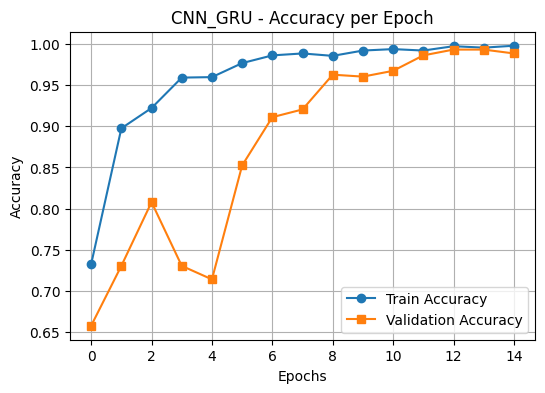

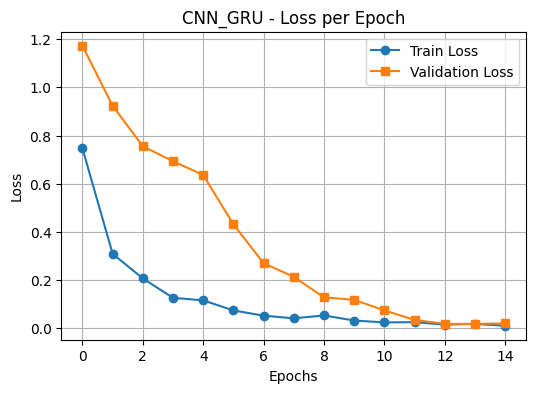


Results for RNN:
Test Accuracy: 0.9719


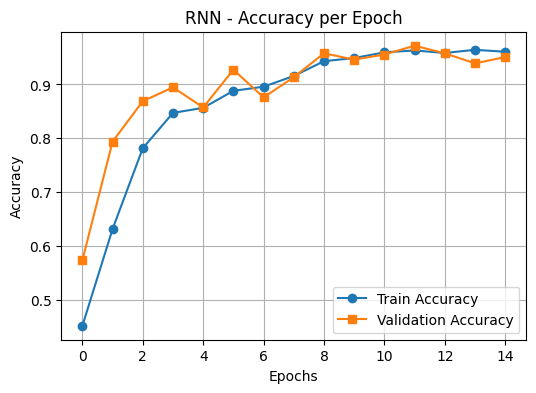

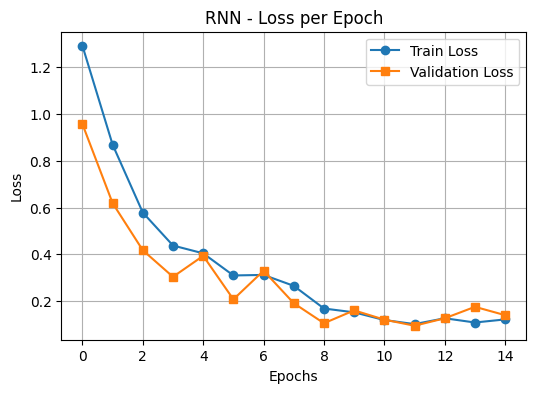


Results for CNN_LSTM:
Test Accuracy: 0.9977


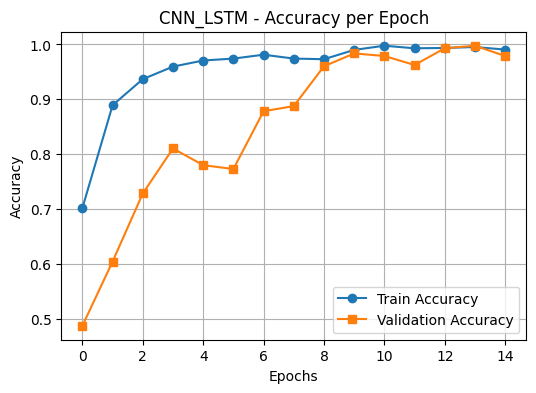

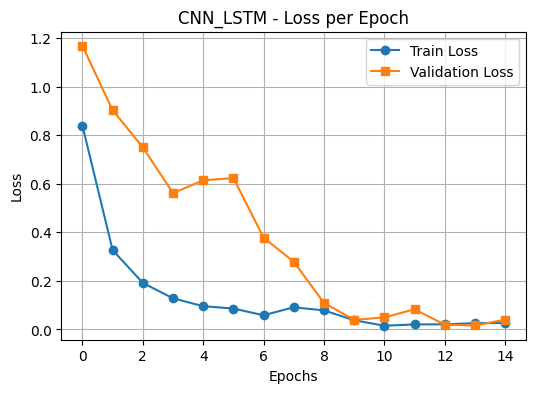


Results for Autoencoder_Classifier:
Test Accuracy: 0.9953


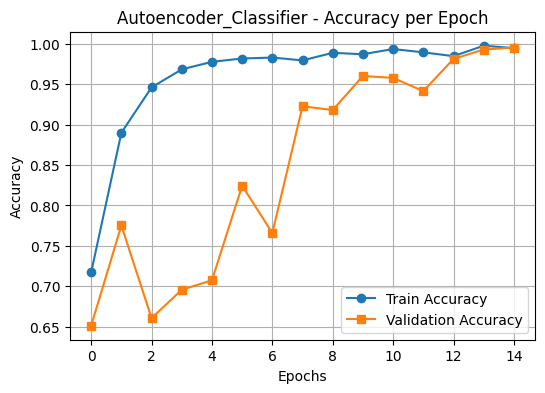

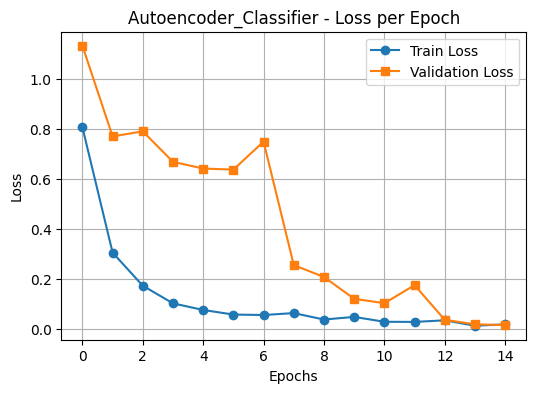

In [12]:
import matplotlib.pyplot as plt

for model_name, result in results.items():
    print(f"\nResults for {model_name}:")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    
    history = result['history']  # history is already a dictionary

    # Plot Training & Validation Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Training & Validation Loss
    plt.figure(figsize=(6, 4))
    plt.plot(history['loss'], label='Train Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()


Loading and Evaluating CNN_GRU...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


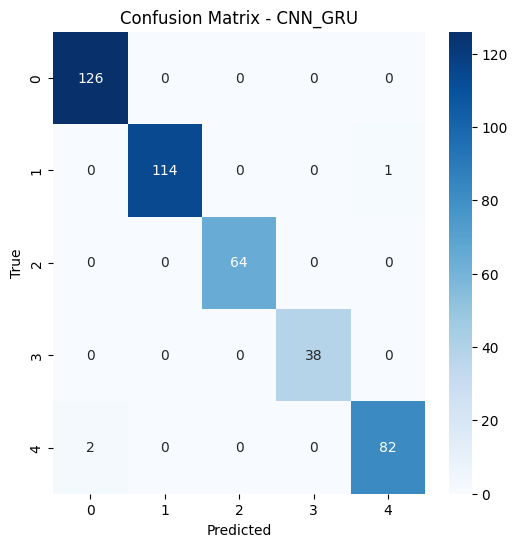

Classification Report for CNN_GRU:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       126
           1       1.00      0.99      1.00       115
           2       1.00      1.00      1.00        64
           3       1.00      1.00      1.00        38
           4       0.99      0.98      0.98        84

    accuracy                           0.99       427
   macro avg       0.99      0.99      0.99       427
weighted avg       0.99      0.99      0.99       427


Loading and Evaluating RNN...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


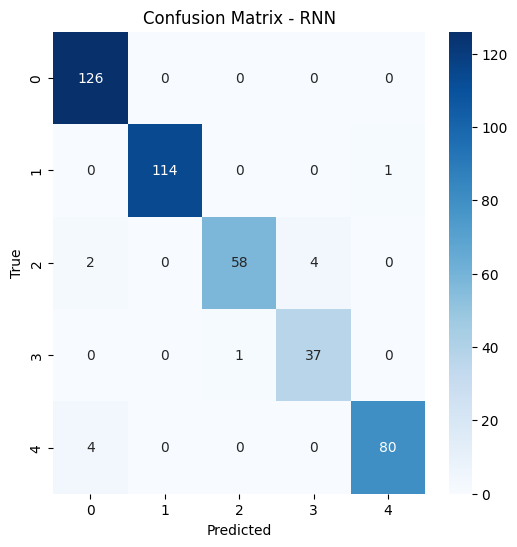

Classification Report for RNN:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       126
           1       1.00      0.99      1.00       115
           2       0.98      0.91      0.94        64
           3       0.90      0.97      0.94        38
           4       0.99      0.95      0.97        84

    accuracy                           0.97       427
   macro avg       0.97      0.96      0.96       427
weighted avg       0.97      0.97      0.97       427


Loading and Evaluating CNN_LSTM...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


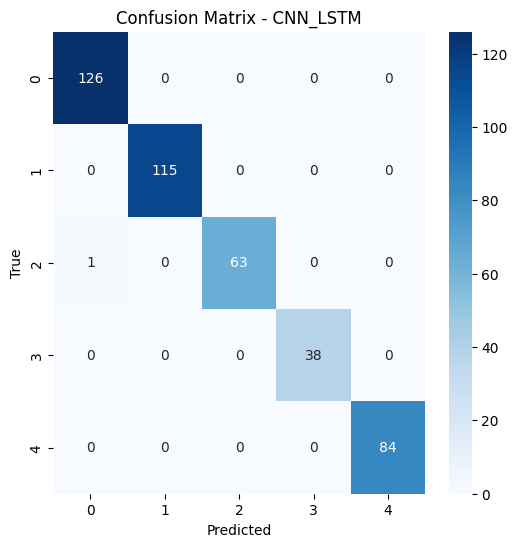

Classification Report for CNN_LSTM:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       126
           1       1.00      1.00      1.00       115
           2       1.00      0.98      0.99        64
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        84

    accuracy                           1.00       427
   macro avg       1.00      1.00      1.00       427
weighted avg       1.00      1.00      1.00       427


Loading and Evaluating Autoencoder_Classifier...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


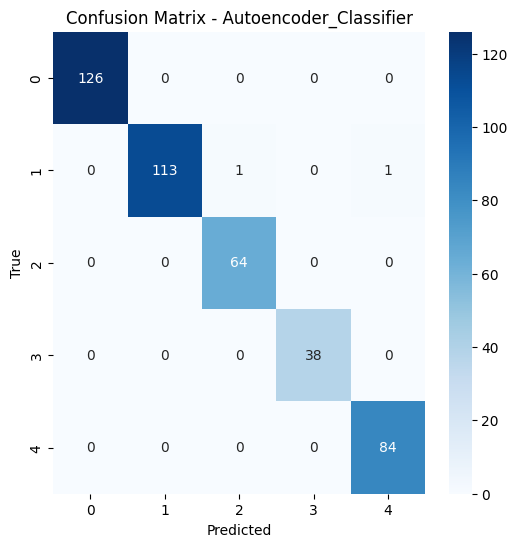

Classification Report for Autoencoder_Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       126
           1       1.00      0.98      0.99       115
           2       0.98      1.00      0.99        64
           3       1.00      1.00      1.00        38
           4       0.99      1.00      0.99        84

    accuracy                           1.00       427
   macro avg       0.99      1.00      1.00       427
weighted avg       1.00      1.00      1.00       427




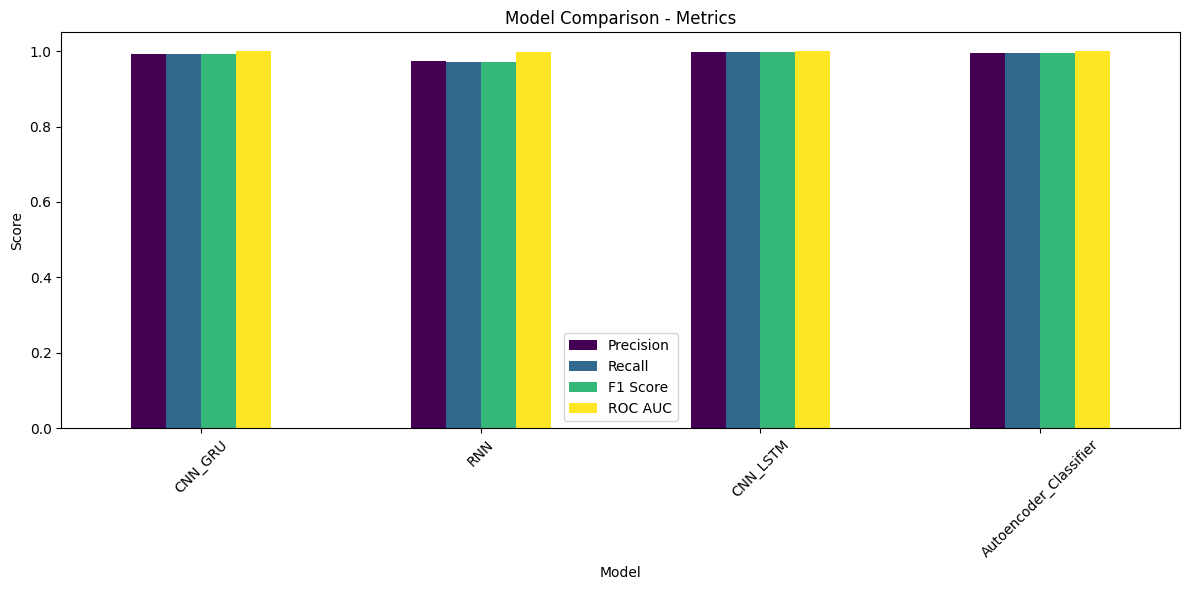

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score

# Function to evaluate each model and plot results
def evaluate_model(model, X_test, y_test, model_name, num_classes):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovr')
    
    class_report = classification_report(y_true, y_pred_classes)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return precision, recall, f1, roc_auc, class_report

# Function to plot model comparison metrics
def plot_comparison(metrics):
    metrics_df = pd.DataFrame(metrics).T
    metrics_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
    plt.title('Model Comparison - Metrics')
    plt.ylabel('Score')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Model file paths (Ensure these .h5 files exist)
models = {
    'CNN_GRU': '../Models/CNN_GRU.h5',
    'RNN': '../Models/RNN.h5',
    'CNN_LSTM': '../Models/CNN_LSTM.h5',
    'Autoencoder_Classifier': '../Models/Autoencoder_Classifier.h5'
}

# Ensure labels are correctly formatted
num_classes = 5  
if len(New_y_test.shape) > 1 and New_y_test.shape[1] == num_classes:
    y_test = New_y_test  # Already one-hot encoded
else:
    y_test = to_categorical(New_y_test, num_classes=num_classes)  # Convert labels to one-hot encoding

# Model evaluation
model_metrics = {}

for model_name, model_path in models.items():
    print(f"Loading and Evaluating {model_name}...")

    model = load_model(model_path)  # Load model using Keras

    precision, recall, f1, roc_auc, class_report = evaluate_model(model, New_X_test, y_test, model_name, num_classes)

    model_metrics[model_name] = {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    print(f"Classification Report for {model_name}:\n{class_report}\n")

# Plot the comparison of models
plot_comparison(model_metrics)


## Testing on Videos

In [14]:
import pandas as pd
import cv2
import mediapipe as mp
import pickle
from sklearn.preprocessing import StandardScaler


In [15]:
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils  # For drawing keypoints
pose = mp_pose.Pose()




# List to store extracted keypoints for saving
keypoints_data = []

def visualize_pose(video_path, max_frames=200, save_csv=True):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("❌ Error: Video file not found or could not be opened.")
        return

    print("✅ Video opened successfully!")

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame_count >= max_frames:
            break

        # Convert to RGB and process with MediaPipe Pose
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            print(f"🟢 Frame {frame_count}: Keypoints detected!")

            # Extract and store keypoints
            row = [frame_count]  # Start with frame number
            h, w, _ = frame.shape  # Get frame size

            for i, landmark in enumerate(results.pose_landmarks.landmark):
                cx, cy = int(landmark.x * w), int(landmark.y * h)  # Convert to pixel coordinates
                print(f"  Keypoint {i}: x={landmark.x:.4f}, y={landmark.y:.4f}, z={landmark.z:.4f}, visibility={landmark.visibility:.4f}")
                
                # Store for CSV
                row.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])
                
                # Overlay keypoint indices on the frame
                cv2.putText(frame, str(i), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 
                            0.5, (0, 255, 0), 2, cv2.LINE_AA)

            # Draw pose landmarks
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Save keypoints data
            if save_csv:
                keypoints_data.append(row)

        else:
            print(f"🔴 Frame {frame_count}: No keypoints detected.")

        cv2.imshow("Pose Visualization", frame)
        frame_count += 1

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    print("✅ Video processing completed!")

    # Save keypoints to CSV
    if save_csv and keypoints_data:
        columns =["Frame"] + [f"K{i}_{c}" for i in range(33) for c in ("x", "y", "z", "visibility")]
        LR_test_keypoints = pd.DataFrame(keypoints_data, columns=columns)
        LR_test_keypoints.to_csv("../Datasets/CSV_DATASET/pose_keypoints.csv", index=False)
        print("📂 Keypoints saved to pose_keypoints.csv")

visualize_pose("../Datasets/Test_Videos/Limping Walk Cycle.mp4")


✅ Video opened successfully!
🟢 Frame 0: Keypoints detected!
  Keypoint 0: x=0.4985, y=0.1562, z=-0.3141, visibility=1.0000
  Keypoint 1: x=0.5018, y=0.1394, z=-0.2924, visibility=1.0000
  Keypoint 2: x=0.5051, y=0.1392, z=-0.2925, visibility=1.0000
  Keypoint 3: x=0.5078, y=0.1390, z=-0.2926, visibility=1.0000
  Keypoint 4: x=0.4904, y=0.1424, z=-0.2974, visibility=1.0000
  Keypoint 5: x=0.4861, y=0.1446, z=-0.2975, visibility=1.0000
  Keypoint 6: x=0.4828, y=0.1469, z=-0.2975, visibility=1.0000
  Keypoint 7: x=0.5111, y=0.1491, z=-0.1645, visibility=1.0000
  Keypoint 8: x=0.4764, y=0.1635, z=-0.1875, visibility=1.0000
  Keypoint 9: x=0.5074, y=0.1781, z=-0.2660, visibility=1.0000
  Keypoint 10: x=0.4919, y=0.1803, z=-0.2727, visibility=1.0000
  Keypoint 11: x=0.5397, y=0.2711, z=-0.0601, visibility=1.0000
  Keypoint 12: x=0.4499, y=0.2836, z=-0.1288, visibility=0.9999
  Keypoint 13: x=0.5578, y=0.3869, z=-0.0082, visibility=0.9817
  Keypoint 14: x=0.4062, y=0.3992, z=-0.1220, visibili

In [16]:
keypoints = pd.read_csv('../Datasets/CSV_DATASET/pose_keypoints.csv')

In [17]:
import pickle
# Load the scaler
with open("../Models/scaler.pkl", "rb") as f:
    new_df_scaler = pickle.load(f)

In [18]:
new_keypoints = keypoints.copy()
new_keypoints.drop("Frame", axis=1, inplace=True)

# Scale keypoints
new_keypoints = new_df_scaler.transform(new_keypoints)

# Reshape for CNN input
new_keypoints = new_keypoints.reshape(new_keypoints.shape[0], 33, 4)  # Ensure correct shape
print(f"✅ Extracted keypoints shape: {new_keypoints.shape}")
print(f"🔹 Sample keypoints (first frame):\n{new_keypoints[0]}")

✅ Extracted keypoints shape: (200, 33, 4)
🔹 Sample keypoints (first frame):
[[ 0.52260735 -0.01609458 -0.55300878  0.37922116]
 [ 0.55464488 -0.0319178  -0.51109104  0.40337064]
 [ 0.5722136  -0.03192411 -0.51113821  0.42330582]
 [ 0.58689694 -0.03171252 -0.51124985  0.39689058]
 [ 0.50149988 -0.00810469 -0.45480613  0.36466013]
 [ 0.48600182  0.01039307 -0.45480521  0.37066163]
 [ 0.47608396  0.03078969 -0.45456218  0.3551079 ]
 [ 0.63794659  0.00648784 -0.32645502  0.49592363]
 [ 0.47897929  0.12006064 -0.05707248  0.38399808]
 [ 0.58157652  0.03515105 -0.5302323   0.43652291]
 [ 0.51199786  0.05514678 -0.45092865  0.41272466]
 [ 0.75686349  0.2585037  -0.23652669  0.61154418]
 [ 0.41964575  0.4231044   0.21473476  0.31554729]
 [ 0.80389762  0.25639482 -0.23444174  1.47036383]
 [ 0.22353935  0.38450247  0.31354654  0.53436328]
 [ 0.79200874  0.22520039 -0.52288867  1.43040447]
 [ 0.35392831  0.17093248  0.06035993  0.50930703]
 [ 0.77695983  0.26234848 -0.56314693  1.38756477]
 [ 0.3

d:\AI_ML_PROJECTS\Biomechanics-of-gait - Copy\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [19]:
models = {
    'CNN_GRU': '../Models/CNN_GRU.h5',
    'RNN': '../Models/RNN.h5',
    'CNN_LSTM': '../Models/CNN_LSTM.h5',
    'Autoencoder_Classifier': '../Models/Autoencoder_Classifier.h5'
}
# Class labels
class_labels = {
    0: "Normal",
    1: "Limping",
    2: "Slouch",
    3: "No Arm Swing",
    4: "Concriduction"
}


In [20]:
import numpy as np
from collections import Counter
from tensorflow.keras.models import load_model

# Iterate through models and show individual outputs
for model_name, model_path in models.items():
    print("\n" + "=" * 50)
    print(f"🔍 Evaluating Model: {model_name}")
    print("=" * 50)

    # Load model
    model = load_model(model_path)  # Use Keras load_model for .h5 files

    # Predict using the model
    predictions = model.predict(new_keypoints)
    predicted_classes = np.argmax(predictions, axis=1)

    # Store frame-wise predictions
    frame_predictions = [class_labels.get(pred, "Unknown") for pred in predicted_classes]

    # Count occurrences of each class
    counter = Counter(predicted_classes)

    # Find the most common class safely
    most_common_class = counter.most_common(1)
    overall_prediction = class_labels.get(most_common_class[0][0], "Unknown") if most_common_class else "No valid predictions"

    # Display class distribution
    print("\n📊 Class Distribution:")
    for key, value in counter.items():
        print(f"{class_labels.get(key, 'Unknown')}: {value} frames")

    # Display overall gait condition
    print(f"\n🚶 Overall Gait Condition (Most Common Prediction): {overall_prediction}")

print("\n✅ Multi-Model Gait Classification Completed.")


🔍 Evaluating Model: CNN_GRU
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step



📊 Class Distribution:
Normal: 37 frames
Slouch: 90 frames
Limping: 72 frames
No Arm Swing: 1 frames

🚶 Overall Gait Condition (Most Common Prediction): Slouch

🔍 Evaluating Model: RNN


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

📊 Class Distribution:


Limping: 164 frames
Concriduction: 6 frames
Normal: 11 frames
Slouch: 14 frames
No Arm Swing: 5 frames

🚶 Overall Gait Condition (Most Common Prediction): Limping

🔍 Evaluating Model: CNN_LSTM


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step



📊 Class Distribution:
Concriduction: 7 frames
Normal: 68 frames
Limping: 79 frames
No Arm Swing: 1 frames
Slouch: 45 frames

🚶 Overall Gait Condition (Most Common Prediction): Limping

🔍 Evaluating Model: Autoencoder_Classifier
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step

📊 Class Distribution:
Concriduction: 4 frames
Slouch: 65 frames
Normal: 50 frames
Limping: 81 frames

🚶 Overall Gait Condition (Most Common Prediction): Limping

✅ Multi-Model Gait Classification Completed.
